In [1]:
!pip install -q kaggle --quiet

In [9]:
!cp kaggle.json ~/.kaggle/

In [10]:
!kaggle datasets download -d wardaddy24/marble-surface-anomaly-detection-2

100% 36.8M/36.8M [00:02<00:00, 21.7MB/s]
100% 36.8M/36.8M [00:02<00:00, 13.7MB/s]


In [ ]:
!unzip marble-surface-anomaly.zip 

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow 
import keras as ks
import os
import cv2
import warnings
warnings.filterwarnings('ignore')

In [18]:
#directories of the train and test set
train_dir = '/content/dataset/train'
test_dir = '/content/dataset/test'

(256, 256, 3)


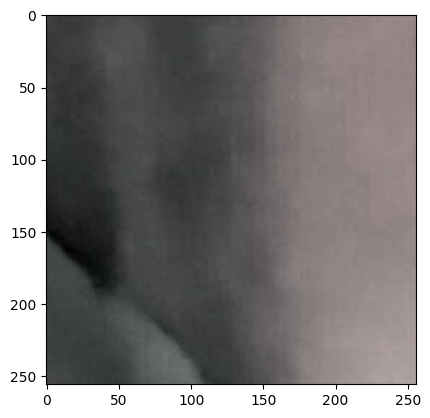

In [19]:
def get_image(path):
    img = cv2.imread(path)
    print(img.shape)
    plt.imshow(img)
image = '/content/dataset/test/crack/_0_0_20210531_17292_0.jpg'
get_image(image)

# Image Data Generator

In [20]:
def datapreprocessing(main_dir,bsize):
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    
    train_gen = ImageDataGenerator(rescale=1.0/255,
                                   zoom_range=0.2,
                                   shear_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   #validation_split=0.3,
                                   fill_mode='nearest',
                                  )

    train_generator = train_gen.flow_from_directory(
        directory=main_dir,
        target_size=(48,48),
        batch_size=bsize,
        color_mode="rgb",
        shuffle=True,
        subset="training",
        class_mode='categorical')
    
    
    
    return train_generator
    

In [21]:
traingen = datapreprocessing(train_dir,20)
validgen = datapreprocessing(test_dir,20)

Found 2249 images belonging to 4 classes.
Found 688 images belonging to 4 classes.


In [22]:
#labelnames
labelnames = traingen.class_indices
labelnames


{'crack': 0, 'dot': 1, 'good': 2, 'joint': 3}

In [23]:
#Function that can build a dataframe on passing folderpath.
def getdata(folder_path):
    sig = pd.DataFrame(columns=['image_abs_path','image_labels'])
    for key,value in labelnames.items():
        #print("processing for label: {}".format(label))
        label_i = folder_path+"/"+str(key)
        #read directory
        dirs_label_i =  os.listdir(label_i)
        idx = 0
        for image in dirs_label_i:
            #create a absolute image path
            sig_i = os.path.join(label_i,image)
            #print('Absolute path for image no. {} and label {}: {}'\
                  #.format(idx,label,flower_i))

            #fill the dataframe with path and label
            sig = sig.append({'image_abs_path':sig_i,
                            'image_labels':key},
                           ignore_index=True)
            idx += 1
    return sig

In [24]:
valid = getdata(test_dir)

In [25]:
valid.sample(5)

,image_abs_path,image_labels
418,/content/dataset/test/good/_768_2560_65.jpg,good
608,/content/dataset/test/good/_1280_256_65.jpg,good
106,/content/dataset/test/crack/_0_2560_20210525_1...,crack
540,/content/dataset/test/good/_256_4096_20210531_...,good
232,/content/dataset/test/crack/_1280_2048_2021053...,crack


In [26]:
# Fetch n number of images from train data frame
def get_n_images(n,df,label):
    import warnings
    warnings.filterwarnings('ignore')
    train = df[df["image_labels"]==label]
    print(len(train))
    i = 0
    m = int(n/2)
    plt.figure(figsize=(12, 6))
    for path in train['image_abs_path'][0:n]:
        plt.subplot(2,m,i+1)
        get_image(path)
        #plt.title(train['image_labels'][i])
        i += 1
    plt.tight_layout()
    plt.show()


In [27]:
def visualize_gen(train_generator):   
    #Visualising Images Processed
    plt.figure(figsize=(6, 3))
    for i in range(0, 10):
        plt.subplot(2, 5, i+1)
        for X_batch, Y_batch in train_generator:
            image = X_batch[0]        
            plt.axis("off")
            plt.imshow((image*255).astype(np.uint8))
            break
    plt.tight_layout()
    plt.show()

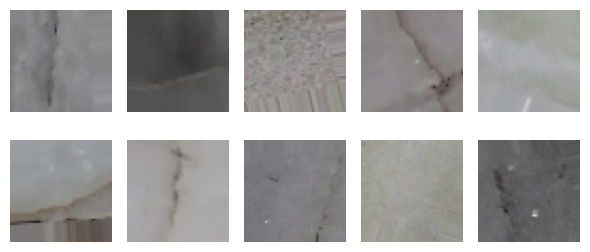

In [28]:
visualize_gen(traingen)

In [42]:
input_shape = traingen.image_shape
input_shape

(48, 48, 3)

# Build Model Architeture

In [43]:
from tensorflow import keras as ks



model02 = ks.models.Sequential()

# Adding layers
model02.add(ks.layers.Conv2D(16, (3, 3), strides=1, activation="relu", padding='same', input_shape=input_shape))
model02.add(ks.layers.MaxPooling2D(pool_size=2, strides=2))
model02.add(ks.layers.Dropout(0.2))

model02.add(ks.layers.Conv2D(32, (3, 3), strides=1, padding="same", activation="relu"))
model02.add(ks.layers.MaxPooling2D(pool_size=2, strides=2))

model02.add(ks.layers.Flatten())
model02.add(ks.layers.Dense(128, activation="relu"))
model02.add(ks.layers.Dropout(0.2))

model02.add(ks.layers.Dense(4, activation="softmax"))

model02.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 16)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 16)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 4608)             

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_loss', patience=20, verbose=2,restore_best_weights=True)

optimizer = ks.optimizers.Adam(learning_rate=0.0001)

model02.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics="accuracy")

history = model02.fit(traingen, epochs=100, callbacks=callback, validation_data=validgen, verbose=1)


In [ ]:
history2 = model02.fit(traingen,initial_epoch=200, epochs=300, callbacks=callback, validation_data=validgen, verbose=1)


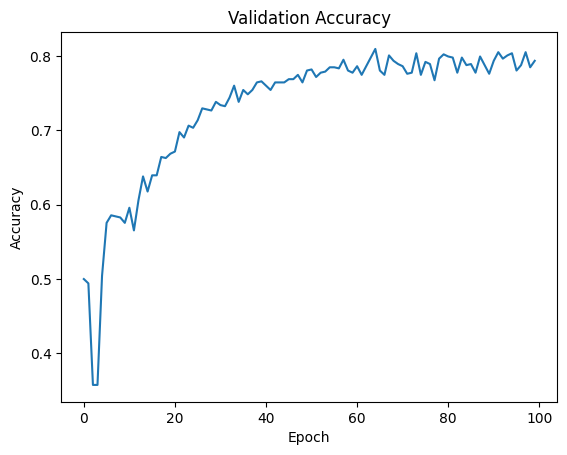

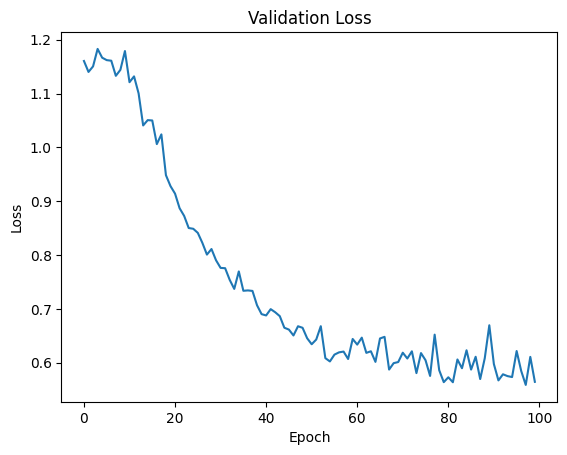

In [45]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plot validation loss
plt.plot(history.history['val_loss'])
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# make predictions on the validation set
y_pred = model02.predict(validgen)

# get the predicted class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# get the true class labels
y_true_classes = validgen.classes

# get the class names
class_names = list(validgen.class_indices.keys())

# plot a confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add the count of each class in the respective cells
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()


1/1 [==============================] - 0s 23ms/step


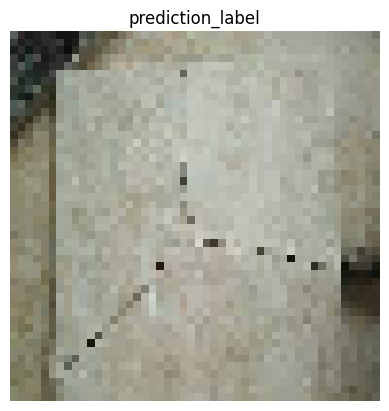

Prediction:  crack


In [81]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the test image
img_path = '/content/44c.jpg'
image_size = (48, 48)  # Define the target image size

# Load and preprocess the image
img = image.load_img(img_path, target_size=image_size)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0  # Normalize the image

# Make predictions on the test image
def predict(image):
    predictions = model.predict(image)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class_name = class_names[predicted_class_index]
    return predicted_class_name

predictions= predict(x)

plt.imshow(img)
plt.title('prediction_label')
plt.axis('off')
plt.show()
print("Prediction: ", predictions)

In [82]:
from google.colab import files

model02.save('marble_surface_modelfin.h5')
files.download('marble_surface_modelfin.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>